# Experiment - Multi-layer neural network 
We evaluate Adam optimizer on Multi-layer neural network using the CIFAR-10 dataset.

### Dataset
In the paper they used the MNIST data set. 
We chose to conduct the experiment with the CIFAR-10 dataset, as it is a more difficult task to learn.

### Optimizers Compared
1. Adam with learnig rate decay
2. SGD with Nesterov momentum
3. Adagrad
4. RMSProp

### HyperParameters
 - All Optimizers are trained with batchsize of 128.
 - Adam optimizer has The stepsize \\(\alpha\\). 
 - In the paper experiments, they did not mention learning rate decay.
 - We trained models both without decay and with learning rate decay adjusted by \\(\alpha_{t}=\frac{1}{\sqrt{t}}\alpha\\), where t is the epoch number. 
 
#### Hyper-parameter search
In the paper the hyper-parameters search was done by a dense grid search. We used optuna library for the search. The results are reported using the best hyper-parameter settings both in the paper and in our experiment.

### Weight Initialization
In the paper the models were initialized with the same weights.
In our experiment we did it as well, and also tried with random initialization for every optimizer.

#### Notes
The paper did not state the best parameter settings, nor the accuracy.

In [73]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import torch.nn as nn
import optuna
import os
import pickle
import matplotlib.pyplot as plt
import math
import numpy as np

In [33]:
batch_size = 128
epochs = 10
input_dim = 3 * 32 * 32
output_dim = 10

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True,
                         download=True, transform=transform)
trainset = torch.utils.data.random_split(trainset, [20000, len(trainset) - 20000])[0]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False,
                        download=True, transform=transform)
testset = torch.utils.data.random_split(testset, [5000, len(testset) - 5000])[0]
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)
num_of_sample = len(trainset)
num_of_test_samples = len(testset)

Files already downloaded and verified
Files already downloaded and verified


### The Multi-layer Model
Multi-layer Model is two fully connected hidden layers with 1000 hidden units each and ReLU activation.

In [23]:
class MultiLayer(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiLayer, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, 1000)
        self.linear2 = torch.nn.Linear(1000, 1000)
        self.linear3 = torch.nn.Linear(1000, output_dim)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.dropout2 = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = x.reshape(x.shape[0], input_dim)
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x.squeeze()

In [9]:
def score(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            labels = torch.tensor(labels, dtype=torch.long)
            images = torch.tensor(images, dtype=torch.float)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [8]:
def save_model_data(name, model, loss_arr, acc_arr):
    run_number = 0
    PATH = f'./ml_models/{name}_{run_number}.pkl'
    while os.path.isfile(PATH):
        run_number += 1
        PATH = f'./ml_models/{name}_{run_number}.pkl'
    torch.save(model.state_dict(), PATH)
    with open(f'ml_models/{name}_loss.pkl', 'wb') as fp:
        pickle.dump(loss_arr, fp)
    with open(f'ml_models/{name}_acc.pkl', 'wb') as fp:
        pickle.dump(acc_arr, fp)

### Training Loop

In [97]:
def train(model, trainloader, optimizer, name, decay=False):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_path = f'./ml_models/{name}_loss.pkl'
    acc_path = f'./ml_models/{name}_acc.pkl'
    lr_path = f'./ml_models/{name}_lr.pkl'
    loss_arr = []
    acc_arr = []
    if os.path.isfile(loss_path) and os.path.getsize(loss_path) > 0:
        with open(loss_path, 'rb') as fp:
            loss_arr = pickle.load(fp)
        with open(acc_path, 'rb') as fp:
            acc_arr = pickle.load(fp)
    decay_factor = lambda x: 1/math.sqrt(len(loss_arr)+1) 
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=decay_factor)
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            labels = torch.tensor(labels, dtype=torch.long)
            inputs = torch.tensor(inputs, dtype=torch.float)
            optimizer.zero_grad()
            outputs = model(inputs.type(torch.float))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if decay:
            scheduler.step()
        loss_arr.append(running_loss/num_of_sample)
        acc_arr.append(score(model, testloader))
        print(f'epoch: {epoch}, loss: {running_loss/num_of_sample}, acc: {acc_arr[-1]}')
    save_model_data(name, model, loss_arr, acc_arr)
    return loss_arr, acc_arr

# Parameter Search

In [71]:
def objective_adam(trial):
    model_adam = MultiLayer(input_dim, output_dim)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    beta_1 = trial.suggest_loguniform("beta_1", 0.6, 1)
    beta_2 = trial.suggest_loguniform("beta_2", 0.9, 1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1)
    optimizer = torch.optim.Adam(model_adam.parameters(), lr=lr, betas=(beta_1, beta_2), weight_decay=weight_decay)
    name = f'adam_no_decay_lr_{optimizer.param_groups[0]["lr"]}_' + \
    f'beta1_{optimizer.param_groups[0]["betas"][0]}_beta2_{optimizer.param_groups[0]["betas"][1]}_' +\
    f'wd_{optimizer.param_groups[0]["weight_decay"]}'
    loss = train(model_adam, trainloader, optimizer, name)
    return score(model_adam, testloader)

def objective_adam_decay(trial):
    model_adam = MultiLayer(input_dim, output_dim)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    beta_1 = trial.suggest_loguniform("beta_1", 0.6, 1)
    beta_2 = trial.suggest_loguniform("beta_2", 0.9, 1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1)
    optimizer = torch.optim.Adam(model_adam.parameters(), lr=lr, betas=(beta_1, beta_2), weight_decay=weight_decay)
    name = f'adam_no_decay_lr_{optimizer.param_groups[0]["lr"]}_' + \
    f'beta1_{optimizer.param_groups[0]["betas"][0]}_beta2_{optimizer.param_groups[0]["betas"][1]}_' +\
    f'wd_{optimizer.param_groups[0]["weight_decay"]}'
    loss = train(model_adam, trainloader, optimizer, name, True)
    return score(model_adam, testloader)

def objective_adagrad(trial):
    model_adagrad = MultiLayer(input_dim, output_dim)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1)
    optimizer = torch.optim.Adagrad(model_adagrad.parameters(), lr=lr, weight_decay=weight_decay)
    name = f'adagrad_lr_{optimizer.param_groups[0]["lr"]}_' + \
    f'wd_{optimizer.param_groups[0]["weight_decay"]}'
    loss = train(model_adagrad, trainloader, optimizer, name)
    return score(model_adagrad, testloader)

def objective_sgd_nst(trial):
    model_sgd_nst = MultiLayer(input_dim, output_dim)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    momentum = trial.suggest_loguniform("momentum", 1e-8, 1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1)
    optimizer = torch.optim.SGD(model_sgd_nst.parameters(), nesterov=True, 
                             momentum=momentum, lr=lr, weight_decay=weight_decay)
    name = f'sgd_nst_lr_{optimizer.param_groups[0]["lr"]}_' + \
    f'momentum_{optimizer.param_groups[0]["momentum"]}' +\
    f'wd_{optimizer.param_groups[0]["weight_decay"]}'
    loss = train(model_sgd_nst, trainloader, optimizer, name)
    return score(model_sgd_nst, testloader)

def objective_rmsprop(trial):
    model_rmsprop = MultiLayer(input_dim, output_dim)
    alpha = trial.suggest_loguniform("alpha", 0.8, 1)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    momentum = trial.suggest_loguniform("momentum", 1e-8, 1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1)
    optimizer = torch.optim.RMSprop(model_rmsprop.parameters(), alpha=alpha, 
                             momentum=momentum, lr=lr, weight_decay=weight_decay)
    name = f'rmsprop_{optimizer.param_groups[0]["lr"]}_' + \
    f'momentum_{optimizer.param_groups[0]["momentum"]}_' +\
    f'wd_{optimizer.param_groups[0]["weight_decay"]}_' +\
    f'alpha_{optimizer.param_groups[0]["alpha"]}'
    loss = train(model_rmsprop, trainloader, optimizer, name)
    return score(model_rmsprop, testloader)

In [37]:
study_adam = optuna.create_study(direction='maximize')
study_adam.optimize(objective_adam, n_trials=10)
best_adam = study_adam.best_trial

[I 2021-04-01 20:24:03,977] A new study created in memory with name: no-name-b299df41-59ad-4b9e-bc37-0b8471a36652
<ipython-input-25-40b4e0437542>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-25-40b4e0437542>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWar

epoch: 0, loss: 0.01643159178495407, acc: 20.76
epoch: 1, loss: 0.016282360589504243, acc: 20.5
epoch: 2, loss: 0.016280548524856567, acc: 21.66
epoch: 3, loss: 0.016254214304685592, acc: 21.56
epoch: 4, loss: 0.016257058036327363, acc: 23.06
epoch: 5, loss: 0.01623612196445465, acc: 23.26
epoch: 6, loss: 0.016208019816875457, acc: 19.4
epoch: 7, loss: 0.01623276118040085, acc: 21.34
epoch: 8, loss: 0.01627373650074005, acc: 19.36
epoch: 9, loss: 0.016287800300121308, acc: 20.56


[I 2021-04-01 20:27:23,213] Trial 0 finished with value: 20.42 and parameters: {'lr': 0.001020677060192541, 'beta_1': 0.670215768599885, 'beta_2': 0.9105704546043026, 'weight_decay': 0.11200431329563469}. Best is trial 0 with value: 20.42.


epoch: 0, loss: 0.1034451824426651, acc: 9.72
epoch: 1, loss: 0.08733062002658844, acc: 9.74
epoch: 2, loss: 0.09966945247650147, acc: 10.1
epoch: 3, loss: 0.10512481101751328, acc: 10.16
epoch: 4, loss: 0.09288045046329499, acc: 12.12
epoch: 5, loss: 0.09649635174274444, acc: 10.26
epoch: 6, loss: 0.09879613854885101, acc: 11.8
epoch: 7, loss: 0.08975911415815353, acc: 10.22
epoch: 8, loss: 0.09678288539648056, acc: 11.7
epoch: 9, loss: 0.1070526034116745, acc: 9.92


[I 2021-04-01 20:30:17,574] Trial 1 finished with value: 9.4 and parameters: {'lr': 0.021378595262592878, 'beta_1': 0.6251104278951343, 'beta_2': 0.9110492500475909, 'weight_decay': 0.041043468472267274}. Best is trial 0 with value: 20.42.


epoch: 0, loss: 0.015293461894989013, acc: 34.12
epoch: 1, loss: 0.01431589331626892, acc: 37.26
epoch: 2, loss: 0.014054941254854202, acc: 35.72
epoch: 3, loss: 0.01398756457567215, acc: 35.98
epoch: 4, loss: 0.013935362184047699, acc: 36.24
epoch: 5, loss: 0.014013578623533248, acc: 37.4
epoch: 6, loss: 0.013937386679649354, acc: 36.54
epoch: 7, loss: 0.013915253764390945, acc: 37.3
epoch: 8, loss: 0.013951617830991745, acc: 37.08
epoch: 9, loss: 0.013900092965364456, acc: 36.42


[I 2021-04-01 20:33:11,726] Trial 2 finished with value: 36.26 and parameters: {'lr': 0.001747929508204596, 'beta_1': 0.887878327899595, 'beta_2': 0.9000040989856465, 'weight_decay': 0.000194753298319545}. Best is trial 2 with value: 36.26.


epoch: 0, loss: 0.0162054287314415, acc: 31.64
epoch: 1, loss: 0.014673350006341934, acc: 35.94
epoch: 2, loss: 0.014174480855464935, acc: 36.56
epoch: 3, loss: 0.013943053245544434, acc: 36.72
epoch: 4, loss: 0.013821388536691665, acc: 37.52
epoch: 5, loss: 0.013708719235658645, acc: 38.64
epoch: 6, loss: 0.013685428774356842, acc: 37.2
epoch: 7, loss: 0.013649251961708068, acc: 38.22
epoch: 8, loss: 0.01361930428147316, acc: 38.88
epoch: 9, loss: 0.013601010316610337, acc: 38.14


[I 2021-04-01 20:36:08,428] Trial 3 finished with value: 37.88 and parameters: {'lr': 7.579993898379934e-05, 'beta_1': 0.667488229786559, 'beta_2': 0.9961210703389578, 'weight_decay': 0.04116541990106469}. Best is trial 3 with value: 37.88.


epoch: 0, loss: 0.015852712607383728, acc: 33.68
epoch: 1, loss: 0.014208123940229416, acc: 38.2
epoch: 2, loss: 0.013673217177391053, acc: 39.28
epoch: 3, loss: 0.013354336857795716, acc: 40.22
epoch: 4, loss: 0.013187436842918397, acc: 40.14
epoch: 5, loss: 0.013038101196289063, acc: 40.72
epoch: 6, loss: 0.012928558325767517, acc: 41.16
epoch: 7, loss: 0.012832590985298157, acc: 41.16
epoch: 8, loss: 0.012756217062473298, acc: 41.68
epoch: 9, loss: 0.01266789116859436, acc: 42.76


[I 2021-04-01 20:39:05,102] Trial 4 finished with value: 42.48 and parameters: {'lr': 7.38102008726633e-05, 'beta_1': 0.7494483146379457, 'beta_2': 0.9977969291918167, 'weight_decay': 0.023727620930396844}. Best is trial 4 with value: 42.48.


epoch: 0, loss: 17.49759181187153, acc: 11.92
epoch: 1, loss: 18.64424214477539, acc: 10.18
epoch: 2, loss: 18.10032105560303, acc: 10.34
epoch: 3, loss: 19.023729988098143, acc: 8.12
epoch: 4, loss: 18.375277044677734, acc: 9.8
epoch: 5, loss: 19.403860275268556, acc: 10.78
epoch: 6, loss: 17.42658945159912, acc: 8.74
epoch: 7, loss: 18.611841903686525, acc: 10.64
epoch: 8, loss: 16.93064175720215, acc: 10.24
epoch: 9, loss: 18.230595495605467, acc: 10.76


[I 2021-04-01 20:42:05,349] Trial 5 finished with value: 10.1 and parameters: {'lr': 0.09597125158612325, 'beta_1': 0.6051866972441391, 'beta_2': 0.9592873088945398, 'weight_decay': 0.8223965897061821}. Best is trial 4 with value: 42.48.


epoch: 0, loss: 0.015499907386302948, acc: 33.5
epoch: 1, loss: 0.014844139665365219, acc: 32.52
epoch: 2, loss: 0.01484731638431549, acc: 33.46
epoch: 3, loss: 0.014729430878162385, acc: 29.96
epoch: 4, loss: 0.014775728213787078, acc: 33.72
epoch: 5, loss: 0.01469529378414154, acc: 33.6
epoch: 6, loss: 0.014743279361724853, acc: 30.8
epoch: 7, loss: 0.014782621604204177, acc: 31.98
epoch: 8, loss: 0.014721272510290146, acc: 32.36
epoch: 9, loss: 0.014728469926118851, acc: 32.72


[I 2021-04-01 20:44:58,258] Trial 6 finished with value: 32.76 and parameters: {'lr': 0.0020427692403982055, 'beta_1': 0.7843506454997393, 'beta_2': 0.9381721754417325, 'weight_decay': 0.0014629359393187945}. Best is trial 4 with value: 42.48.


epoch: 0, loss: 0.1324524948954582, acc: 11.94
epoch: 1, loss: 0.10723671834468841, acc: 10.56
epoch: 2, loss: 0.10719809820652008, acc: 12.58
epoch: 3, loss: 0.11307128829956055, acc: 10.94
epoch: 4, loss: 0.10833207235336303, acc: 10.54
epoch: 5, loss: 0.11162993779182434, acc: 10.62
epoch: 6, loss: 0.12178072881698608, acc: 12.3
epoch: 7, loss: 0.11237182788848878, acc: 9.1
epoch: 8, loss: 0.11807513852119446, acc: 10.66
epoch: 9, loss: 0.13341160471439362, acc: 10.96


[I 2021-04-01 20:47:56,032] Trial 7 finished with value: 10.88 and parameters: {'lr': 0.027304822938922783, 'beta_1': 0.8649230264474879, 'beta_2': 0.9075776210068284, 'weight_decay': 0.13323323097700782}. Best is trial 4 with value: 42.48.


epoch: 0, loss: 0.014524639880657195, acc: 39.4
epoch: 1, loss: 0.013175240987539291, acc: 40.22
epoch: 2, loss: 0.012592207831144333, acc: 41.58
epoch: 3, loss: 0.012162111431360244, acc: 44.4
epoch: 4, loss: 0.01183063650727272, acc: 44.64
epoch: 5, loss: 0.011564192497730255, acc: 43.74
epoch: 6, loss: 0.011310249900817871, acc: 45.58
epoch: 7, loss: 0.01112217418551445, acc: 45.52
epoch: 8, loss: 0.010929269027709961, acc: 44.68
epoch: 9, loss: 0.010678871101140975, acc: 46.18


[I 2021-04-01 20:51:54,320] Trial 8 finished with value: 46.06 and parameters: {'lr': 0.0003542627093420311, 'beta_1': 0.6514021259811551, 'beta_2': 0.9045026683691196, 'weight_decay': 0.0010786872219658954}. Best is trial 8 with value: 46.06.


epoch: 0, loss: 0.015839502984285353, acc: 32.6
epoch: 1, loss: 0.014666464275121688, acc: 34.5
epoch: 2, loss: 0.014492871516942977, acc: 35.54
epoch: 3, loss: 0.014361650454998017, acc: 34.2
epoch: 4, loss: 0.014381337916851044, acc: 34.38
epoch: 5, loss: 0.01430731058716774, acc: 34.76
epoch: 6, loss: 0.01430984686613083, acc: 34.8
epoch: 7, loss: 0.014303227514028549, acc: 34.92
epoch: 8, loss: 0.014301278126239776, acc: 35.18
epoch: 9, loss: 0.014296659910678864, acc: 34.74


[I 2021-04-01 20:56:35,943] Trial 9 finished with value: 35.1 and parameters: {'lr': 0.0001541348978377523, 'beta_1': 0.7244923193224967, 'beta_2': 0.9836285652794294, 'weight_decay': 0.05555760935678044}. Best is trial 8 with value: 46.06.


In [77]:
study_adam_decay = optuna.create_study(direction='maximize')
study_adam_decay.optimize(objective_adam_decay, n_trials=10)
best_adam_decay = study_adam_decay.best_trial

[I 2021-04-02 11:31:49,132] A new study created in memory with name: no-name-1617926e-c3da-49c7-a684-a60458fa72a8
<ipython-input-76-b6183d877785>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-76-b6183d877785>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWar

epoch: 0, loss: 0.015467432141304017, acc: 27.12
epoch: 1, loss: 0.015162850672006607, acc: 30.3
epoch: 2, loss: 0.014701602298021317, acc: 30.18
epoch: 3, loss: 0.014388199102878571, acc: 30.8
epoch: 4, loss: 0.0142052783370018, acc: 35.14
epoch: 5, loss: 0.014003169322013854, acc: 36.6
epoch: 6, loss: 0.013848395222425461, acc: 36.8
epoch: 7, loss: 0.013709391498565674, acc: 36.98
epoch: 8, loss: 0.013578702116012573, acc: 38.7
epoch: 9, loss: 0.013495231992006302, acc: 36.48


[I 2021-04-02 11:37:02,580] Trial 0 finished with value: 37.56 and parameters: {'lr': 0.001784894685625764, 'beta_1': 0.6465134105210215, 'beta_2': 0.9969159779980987, 'weight_decay': 0.007110251206855123}. Best is trial 0 with value: 37.56.


epoch: 0, loss: 0.016548264586925508, acc: 22.84
epoch: 1, loss: 0.01635934702157974, acc: 21.96
epoch: 2, loss: 0.01633636386394501, acc: 21.12
epoch: 3, loss: 0.0162499833881855, acc: 22.88
epoch: 4, loss: 0.0162160471200943, acc: 23.1
epoch: 5, loss: 0.016189860105514528, acc: 23.84
epoch: 6, loss: 0.01618198146224022, acc: 22.66
epoch: 7, loss: 0.016139049911499025, acc: 23.5
epoch: 8, loss: 0.01612291941046715, acc: 23.62
epoch: 9, loss: 0.01613091511130333, acc: 24.04


[I 2021-04-02 11:42:15,638] Trial 1 finished with value: 24.14 and parameters: {'lr': 0.0007847251979691488, 'beta_1': 0.7341100467122278, 'beta_2': 0.9998681437287783, 'weight_decay': 0.12747908580449763}. Best is trial 0 with value: 37.56.


epoch: 0, loss: 0.01805658371448517, acc: 9.68
epoch: 1, loss: 0.018075535237789153, acc: 10.3
epoch: 2, loss: 0.018075429701805115, acc: 10.24
epoch: 3, loss: 0.01807536907196045, acc: 10.24
epoch: 4, loss: 0.01807530256509781, acc: 10.24
epoch: 5, loss: 0.01807531325817108, acc: 10.24
epoch: 6, loss: 0.018075340139865875, acc: 10.24
epoch: 7, loss: 0.01807528487443924, acc: 10.24
epoch: 8, loss: 0.01807530905008316, acc: 10.24
epoch: 9, loss: 0.018075291514396668, acc: 10.24


[I 2021-04-02 11:46:41,344] Trial 2 finished with value: 10.24 and parameters: {'lr': 0.0005786937318220881, 'beta_1': 0.8397314521062732, 'beta_2': 0.9640622432465494, 'weight_decay': 0.4434845517704658}. Best is trial 0 with value: 37.56.


epoch: 0, loss: 0.017988526475429534, acc: 17.18
epoch: 1, loss: 0.017790535652637482, acc: 21.96
epoch: 2, loss: 0.017675511968135833, acc: 24.06
epoch: 3, loss: 0.01759519135951996, acc: 24.04
epoch: 4, loss: 0.017536230528354645, acc: 24.18
epoch: 5, loss: 0.017487675368785857, acc: 23.54
epoch: 6, loss: 0.01744303604364395, acc: 24.04
epoch: 7, loss: 0.01740476711988449, acc: 23.84
epoch: 8, loss: 0.01736770943403244, acc: 24.04
epoch: 9, loss: 0.017330833518505097, acc: 23.14


[I 2021-04-02 11:51:10,579] Trial 3 finished with value: 23.42 and parameters: {'lr': 1.2153241882720888e-05, 'beta_1': 0.6595936874885554, 'beta_2': 0.9139184271449912, 'weight_decay': 0.1702529644516688}. Best is trial 0 with value: 37.56.


epoch: 0, loss: 0.01672652087211609, acc: 23.24
epoch: 1, loss: 0.01644191339612007, acc: 22.14
epoch: 2, loss: 0.01636729155778885, acc: 23.7
epoch: 3, loss: 0.016277076345682144, acc: 23.22
epoch: 4, loss: 0.016220942372083665, acc: 23.64
epoch: 5, loss: 0.01627598847746849, acc: 23.98
epoch: 6, loss: 0.016215095096826553, acc: 22.92
epoch: 7, loss: 0.016210302263498306, acc: 22.64
epoch: 8, loss: 0.0161907073199749, acc: 23.6
epoch: 9, loss: 0.016191075360774992, acc: 23.52


[I 2021-04-02 11:55:27,413] Trial 4 finished with value: 23.38 and parameters: {'lr': 0.0004603926612754228, 'beta_1': 0.7277393863583638, 'beta_2': 0.9902596199327451, 'weight_decay': 0.14103455675956889}. Best is trial 0 with value: 37.56.


epoch: 0, loss: 0.015908472675085068, acc: 25.72
epoch: 1, loss: 0.01577876392006874, acc: 24.72
epoch: 2, loss: 0.015654840874671935, acc: 29.12
epoch: 3, loss: 0.015466749423742295, acc: 28.02
epoch: 4, loss: 0.015399813008308411, acc: 28.98
epoch: 5, loss: 0.015432672011852264, acc: 30.72
epoch: 6, loss: 0.015376393449306488, acc: 29.28
epoch: 7, loss: 0.015316621875762939, acc: 29.1
epoch: 8, loss: 0.015307862615585328, acc: 29.72
epoch: 9, loss: 0.015335711002349853, acc: 28.74


[I 2021-04-02 11:59:44,846] Trial 5 finished with value: 29.04 and parameters: {'lr': 0.0024071691039035943, 'beta_1': 0.9648258911411923, 'beta_2': 0.9211658466721779, 'weight_decay': 0.07258152790170398}. Best is trial 0 with value: 37.56.


epoch: 0, loss: 0.026724445402622223, acc: 15.16
epoch: 1, loss: 0.018264021551609038, acc: 16.32
epoch: 2, loss: 0.01792473247051239, acc: 20.82
epoch: 3, loss: 0.017272804749011994, acc: 20.0
epoch: 4, loss: 0.016946886885166167, acc: 23.26
epoch: 5, loss: 0.01677325361967087, acc: 24.16
epoch: 6, loss: 0.016593113887310027, acc: 22.14
epoch: 7, loss: 0.016314889580011368, acc: 25.62
epoch: 8, loss: 0.016206606739759447, acc: 25.8
epoch: 9, loss: 0.016089343523979185, acc: 26.88


[I 2021-04-02 12:04:20,619] Trial 6 finished with value: 26.5 and parameters: {'lr': 0.01167899689422621, 'beta_1': 0.9455628291269589, 'beta_2': 0.9439753095183754, 'weight_decay': 0.0019041926128696841}. Best is trial 0 with value: 37.56.


epoch: 0, loss: 0.01455732061266899, acc: 38.2
epoch: 1, loss: 0.013235412734746934, acc: 41.36
epoch: 2, loss: 0.012429195934534072, acc: 43.84
epoch: 3, loss: 0.011896970808506012, acc: 44.28
epoch: 4, loss: 0.011550519865751266, acc: 44.74
epoch: 5, loss: 0.01123914487361908, acc: 45.78
epoch: 6, loss: 0.010933239477872848, acc: 47.2
epoch: 7, loss: 0.010749156504869462, acc: 46.58
epoch: 8, loss: 0.010493901771306992, acc: 45.98
epoch: 9, loss: 0.010289035406708717, acc: 47.2


[I 2021-04-02 12:08:54,547] Trial 7 finished with value: 47.34 and parameters: {'lr': 0.0002699503024594839, 'beta_1': 0.8025840805598217, 'beta_2': 0.9011754833493109, 'weight_decay': 0.0014670153159161141}. Best is trial 7 with value: 47.34.


epoch: 0, loss: 0.017075858402252196, acc: 17.02
epoch: 1, loss: 0.017039201402664184, acc: 17.34
epoch: 2, loss: 0.016968935656547546, acc: 16.64
epoch: 3, loss: 0.01690674684047699, acc: 17.28
epoch: 4, loss: 0.016874465668201447, acc: 16.4
epoch: 5, loss: 0.016878563725948335, acc: 17.18
epoch: 6, loss: 0.016835790288448334, acc: 17.7
epoch: 7, loss: 0.01679201999902725, acc: 17.28
epoch: 8, loss: 0.01683599613904953, acc: 17.98
epoch: 9, loss: 0.016797473967075347, acc: 17.88


[I 2021-04-02 12:13:41,712] Trial 8 finished with value: 17.72 and parameters: {'lr': 0.002694644221654086, 'beta_1': 0.8022720141366706, 'beta_2': 0.9318914839912201, 'weight_decay': 0.15360781811042531}. Best is trial 7 with value: 47.34.


epoch: 0, loss: 0.5502207005620002, acc: 9.6
epoch: 1, loss: 0.18346394313573838, acc: 9.46
epoch: 2, loss: 0.04563656196594238, acc: 11.66
epoch: 3, loss: 0.06262148065567016, acc: 9.48
epoch: 4, loss: 0.03523837580680847, acc: 12.04
epoch: 5, loss: 0.03317409617900848, acc: 11.24
epoch: 6, loss: 0.03120692034959793, acc: 11.2
epoch: 7, loss: 0.026998911738395692, acc: 12.54
epoch: 8, loss: 0.027410262215137482, acc: 12.14
epoch: 9, loss: 0.02644427500963211, acc: 12.14


[I 2021-04-02 12:18:14,425] Trial 9 finished with value: 13.18 and parameters: {'lr': 0.04635724258026274, 'beta_1': 0.7241391262137044, 'beta_2': 0.9453630656357751, 'weight_decay': 0.0003903541096625161}. Best is trial 7 with value: 47.34.


In [39]:
study_adagrad = optuna.create_study(direction='maximize')
study_adagrad.optimize(objective_adagrad, n_trials=10)
best_adagrad = study_adagrad.best_trial

[I 2021-04-01 21:07:18,728] A new study created in memory with name: no-name-89ea23f0-28cd-40c9-991a-fafdc418d76a
<ipython-input-25-40b4e0437542>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-25-40b4e0437542>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWar

epoch: 0, loss: 0.014492631429433822, acc: 37.28
epoch: 1, loss: 0.012991537177562714, acc: 41.3
epoch: 2, loss: 0.012408262777328491, acc: 43.82
epoch: 3, loss: 0.011996367573738098, acc: 43.22
epoch: 4, loss: 0.011679988265037536, acc: 44.6
epoch: 5, loss: 0.01137407073378563, acc: 45.14
epoch: 6, loss: 0.011097254484891891, acc: 45.66
epoch: 7, loss: 0.01093731026649475, acc: 46.26
epoch: 8, loss: 0.010741873610019683, acc: 46.82
epoch: 9, loss: 0.01057467918395996, acc: 47.22


[I 2021-04-01 21:12:00,011] Trial 0 finished with value: 46.7 and parameters: {'lr': 0.0027573182025304294, 'weight_decay': 1.5894609845877e-08}. Best is trial 0 with value: 46.7.


epoch: 0, loss: 0.016693735593557357, acc: 21.0
epoch: 1, loss: 0.016405980038642885, acc: 23.18
epoch: 2, loss: 0.016300141006708145, acc: 22.44
epoch: 3, loss: 0.016253882789611818, acc: 22.32
epoch: 4, loss: 0.016228610408306123, acc: 23.24
epoch: 5, loss: 0.016205922770500182, acc: 23.18
epoch: 6, loss: 0.016191966766119004, acc: 23.56
epoch: 7, loss: 0.01616632189154625, acc: 23.28
epoch: 8, loss: 0.016163052946329116, acc: 23.22
epoch: 9, loss: 0.016138123375177383, acc: 23.5


[I 2021-04-01 21:16:16,484] Trial 1 finished with value: 23.42 and parameters: {'lr': 0.0026367992331416826, 'weight_decay': 0.14123126723412222}. Best is trial 0 with value: 46.7.


epoch: 0, loss: 0.01447521007657051, acc: 37.72
epoch: 1, loss: 0.013297321265935897, acc: 40.66
epoch: 2, loss: 0.01282036810517311, acc: 41.58
epoch: 3, loss: 0.012600124841928483, acc: 42.9
epoch: 4, loss: 0.012362982827425003, acc: 43.98
epoch: 5, loss: 0.01215331015586853, acc: 43.0
epoch: 6, loss: 0.01196531098484993, acc: 43.58
epoch: 7, loss: 0.011842016559839248, acc: 44.14
epoch: 8, loss: 0.011694199961423873, acc: 44.3
epoch: 9, loss: 0.011551041090488434, acc: 45.16


[I 2021-04-01 21:20:36,594] Trial 2 finished with value: 45.18 and parameters: {'lr': 0.0010067922433332078, 'weight_decay': 0.0019034416496362093}. Best is trial 0 with value: 46.7.


epoch: 0, loss: 0.017719571912288665, acc: 21.8
epoch: 1, loss: 0.01735168081521988, acc: 23.94
epoch: 2, loss: 0.017103637766838074, acc: 24.8
epoch: 3, loss: 0.016903573495149614, acc: 25.52
epoch: 4, loss: 0.01676973786354065, acc: 26.32
epoch: 5, loss: 0.016635491311550142, acc: 26.22
epoch: 6, loss: 0.01650656999349594, acc: 27.22
epoch: 7, loss: 0.01641382772922516, acc: 27.1
epoch: 8, loss: 0.016324911534786223, acc: 27.84
epoch: 9, loss: 0.01624026272892952, acc: 28.72


[I 2021-04-01 21:25:05,078] Trial 3 finished with value: 27.44 and parameters: {'lr': 3.2779079970025365e-05, 'weight_decay': 1.6209023889406572e-06}. Best is trial 0 with value: 46.7.


epoch: 0, loss: 0.01700769329071045, acc: 27.12
epoch: 1, loss: 0.016166129356622694, acc: 29.4
epoch: 2, loss: 0.015735965424776076, acc: 30.58
epoch: 3, loss: 0.015457122325897217, acc: 31.38
epoch: 4, loss: 0.015221328097581864, acc: 31.64
epoch: 5, loss: 0.015039150500297546, acc: 33.26
epoch: 6, loss: 0.014897268503904342, acc: 33.0
epoch: 7, loss: 0.014785132491588592, acc: 33.56
epoch: 8, loss: 0.014676054394245148, acc: 34.96
epoch: 9, loss: 0.014594583183526993, acc: 34.74


[I 2021-04-01 21:29:33,502] Trial 4 finished with value: 34.6 and parameters: {'lr': 9.147025013253204e-05, 'weight_decay': 6.884910391964378e-07}. Best is trial 0 with value: 46.7.


epoch: 0, loss: 0.015127851194143295, acc: 39.42
epoch: 1, loss: 0.012986668366193771, acc: 40.58
epoch: 2, loss: 0.012317047280073165, acc: 43.54
epoch: 3, loss: 0.011817107969522476, acc: 44.32
epoch: 4, loss: 0.011526309835910797, acc: 45.16
epoch: 5, loss: 0.011153509044647217, acc: 44.72
epoch: 6, loss: 0.010870935028791428, acc: 44.76
epoch: 7, loss: 0.010671831631660461, acc: 46.3
epoch: 8, loss: 0.010446009248495102, acc: 47.02
epoch: 9, loss: 0.010205428898334503, acc: 46.54


[I 2021-04-01 21:33:59,217] Trial 5 finished with value: 47.68 and parameters: {'lr': 0.004735911007953163, 'weight_decay': 1.105389982140552e-06}. Best is trial 5 with value: 47.68.


epoch: 0, loss: 0.0163542846262455, acc: 28.7
epoch: 1, loss: 0.015675894093513488, acc: 29.3
epoch: 2, loss: 0.015489595317840577, acc: 29.7
epoch: 3, loss: 0.015378087002038956, acc: 29.58
epoch: 4, loss: 0.015332659143209457, acc: 29.3
epoch: 5, loss: 0.01530013620853424, acc: 30.34
epoch: 6, loss: 0.015283883875608445, acc: 30.12
epoch: 7, loss: 0.015255350267887116, acc: 30.02
epoch: 8, loss: 0.015242575037479401, acc: 30.6
epoch: 9, loss: 0.015216972088813781, acc: 31.12


[I 2021-04-01 21:39:04,401] Trial 6 finished with value: 31.22 and parameters: {'lr': 0.0008844298479202145, 'weight_decay': 0.09560929810097078}. Best is trial 5 with value: 47.68.


epoch: 0, loss: 0.017514050996303557, acc: 24.56
epoch: 1, loss: 0.01697843095064163, acc: 26.04
epoch: 2, loss: 0.01665386164188385, acc: 26.74
epoch: 3, loss: 0.01643237516283989, acc: 27.42
epoch: 4, loss: 0.016235169452428817, acc: 28.66
epoch: 5, loss: 0.01608362020254135, acc: 29.5
epoch: 6, loss: 0.015953747016191483, acc: 29.84
epoch: 7, loss: 0.01583185799717903, acc: 29.86
epoch: 8, loss: 0.01573310289978981, acc: 30.0
epoch: 9, loss: 0.015652634674310686, acc: 30.56


[I 2021-04-01 21:43:44,140] Trial 7 finished with value: 30.08 and parameters: {'lr': 4.7200601737715254e-05, 'weight_decay': 0.000415328060722511}. Best is trial 5 with value: 47.68.


epoch: 0, loss: 0.017710457682609558, acc: 21.28
epoch: 1, loss: 0.017347918713092804, acc: 24.5
epoch: 2, loss: 0.01711695462465286, acc: 24.94
epoch: 3, loss: 0.016947844004631042, acc: 25.06
epoch: 4, loss: 0.016802696073055266, acc: 25.98
epoch: 5, loss: 0.016666159641742707, acc: 25.7
epoch: 6, loss: 0.0165693687915802, acc: 26.36
epoch: 7, loss: 0.01647748291492462, acc: 26.54
epoch: 8, loss: 0.016395451951026915, acc: 27.3
epoch: 9, loss: 0.016310652911663056, acc: 27.92


[I 2021-04-01 21:48:11,155] Trial 8 finished with value: 27.86 and parameters: {'lr': 3.0349388462807386e-05, 'weight_decay': 6.90481794715777e-05}. Best is trial 5 with value: 47.68.


epoch: 0, loss: 1.0428248415231705, acc: 19.06
epoch: 1, loss: 0.01828439540863037, acc: 19.8
epoch: 2, loss: 0.017416313028335573, acc: 21.06
epoch: 3, loss: 0.01695602957010269, acc: 22.64
epoch: 4, loss: 0.016431642204523086, acc: 23.64
epoch: 5, loss: 0.01601444252729416, acc: 24.54
epoch: 6, loss: 0.01581296525001526, acc: 26.1
epoch: 7, loss: 0.015471858644485473, acc: 26.36
epoch: 8, loss: 0.015308153748512267, acc: 26.84
epoch: 9, loss: 0.015056358379125594, acc: 28.98


[I 2021-04-01 21:52:46,900] Trial 9 finished with value: 29.38 and parameters: {'lr': 0.07409687021788494, 'weight_decay': 4.8479536336872745e-08}. Best is trial 5 with value: 47.68.


In [40]:
study_sgd_nst = optuna.create_study(direction='maximize')
study_sgd_nst.optimize(objective_sgd_nst, n_trials=10)
best_sgd_nst = study_sgd_nst.best_trial

[I 2021-04-01 21:52:46,920] A new study created in memory with name: no-name-a17f423d-10ff-48a6-9bb8-e0cff9daf766
<ipython-input-25-40b4e0437542>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-25-40b4e0437542>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWar

epoch: 0, loss: 0.017990535604953766, acc: 16.64
epoch: 1, loss: 0.017786473047733307, acc: 20.6
epoch: 2, loss: 0.017640237498283386, acc: 21.9
epoch: 3, loss: 0.017504298305511475, acc: 24.08
epoch: 4, loss: 0.017382628786563874, acc: 23.3
epoch: 5, loss: 0.01726069036722183, acc: 23.74
epoch: 6, loss: 0.01715422284603119, acc: 24.22
epoch: 7, loss: 0.017063637340068816, acc: 23.88
epoch: 8, loss: 0.01696456253528595, acc: 24.12
epoch: 9, loss: 0.016892763495445252, acc: 23.64


[I 2021-04-01 21:57:20,076] Trial 0 finished with value: 23.28 and parameters: {'lr': 0.002712789864684013, 'momentum': 7.491717239580096e-08, 'weight_decay': 0.12990023525873698}. Best is trial 0 with value: 23.28.


epoch: 0, loss: 0.018099746072292328, acc: 10.48
epoch: 1, loss: 0.018095207607746123, acc: 10.22
epoch: 2, loss: 0.0181023712515831, acc: 10.52
epoch: 3, loss: 0.018092610383033753, acc: 10.7
epoch: 4, loss: 0.018090358424186707, acc: 10.44
epoch: 5, loss: 0.018086514806747438, acc: 11.24
epoch: 6, loss: 0.018077995312213897, acc: 10.56
epoch: 7, loss: 0.01807408562898636, acc: 11.54
epoch: 8, loss: 0.01808562217950821, acc: 10.8
epoch: 9, loss: 0.018065783190727235, acc: 10.5


[I 2021-04-01 22:01:45,254] Trial 1 finished with value: 10.76 and parameters: {'lr': 3.1575305250954486e-05, 'momentum': 7.793907750868163e-05, 'weight_decay': 0.001801812488883748}. Best is trial 0 with value: 23.28.


epoch: 0, loss: 0.01808141611814499, acc: 11.1
epoch: 1, loss: 0.018076623952388765, acc: 11.56
epoch: 2, loss: 0.018081207287311555, acc: 11.24
epoch: 3, loss: 0.01807720674276352, acc: 11.76
epoch: 4, loss: 0.018063019239902497, acc: 11.02
epoch: 5, loss: 0.018067445063591002, acc: 11.18
epoch: 6, loss: 0.01805718960762024, acc: 11.34
epoch: 7, loss: 0.018062277173995972, acc: 11.7
epoch: 8, loss: 0.018046075284481048, acc: 11.52
epoch: 9, loss: 0.01804529722929001, acc: 12.08


[I 2021-04-01 22:06:11,846] Trial 2 finished with value: 12.1 and parameters: {'lr': 3.676880673782601e-05, 'momentum': 0.011388942165068505, 'weight_decay': 0.0018107532986915147}. Best is trial 0 with value: 23.28.


epoch: 0, loss: 0.018101696038246153, acc: 9.3
epoch: 1, loss: 0.018095991933345795, acc: 9.68
epoch: 2, loss: 0.018085819029808044, acc: 10.16
epoch: 3, loss: 0.01807182660102844, acc: 10.74
epoch: 4, loss: 0.018073442459106446, acc: 10.4
epoch: 5, loss: 0.018066922307014465, acc: 10.5
epoch: 6, loss: 0.018057988679409026, acc: 11.04
epoch: 7, loss: 0.01805852321386337, acc: 10.92
epoch: 8, loss: 0.018053426134586333, acc: 11.04
epoch: 9, loss: 0.018045455157756806, acc: 11.38


[I 2021-04-01 22:10:42,630] Trial 3 finished with value: 11.8 and parameters: {'lr': 4.118103881029583e-05, 'momentum': 0.32387221973505315, 'weight_decay': 0.9438073160795555}. Best is trial 0 with value: 23.28.


epoch: 0, loss: 0.017999868977069854, acc: 18.9
epoch: 1, loss: 0.01801983369588852, acc: 19.96
epoch: 2, loss: 0.01805468591451645, acc: 20.4
epoch: 3, loss: 0.018069070839881896, acc: 13.52
epoch: 4, loss: 0.018073567867279053, acc: 9.86
epoch: 5, loss: 0.01807480401992798, acc: 10.46
epoch: 6, loss: 0.018075153076648712, acc: 10.24
epoch: 7, loss: 0.01807525968551636, acc: 10.24
epoch: 8, loss: 0.018075259292125702, acc: 10.24
epoch: 9, loss: 0.0180752583026886, acc: 10.24


[I 2021-04-01 22:15:08,431] Trial 4 finished with value: 10.24 and parameters: {'lr': 0.0039624116115963524, 'momentum': 1.8511809371837086e-07, 'weight_decay': 0.7833378015197486}. Best is trial 0 with value: 23.28.


epoch: 0, loss: 0.017044593048095705, acc: 26.96
epoch: 1, loss: 0.015409105616807937, acc: 32.58
epoch: 2, loss: 0.014570292925834656, acc: 34.88
epoch: 3, loss: 0.014023168033361434, acc: 36.6
epoch: 4, loss: 0.013591029453277588, acc: 38.72
epoch: 5, loss: 0.013313327795267105, acc: 40.18
epoch: 6, loss: 0.013031869059801101, acc: 40.54
epoch: 7, loss: 0.012823923289775848, acc: 41.52
epoch: 8, loss: 0.012583369624614716, acc: 42.2
epoch: 9, loss: 0.012428096413612366, acc: 43.02


[I 2021-04-01 22:19:35,451] Trial 5 finished with value: 43.28 and parameters: {'lr': 0.02206734661775577, 'momentum': 0.000995927672447042, 'weight_decay': 0.0010323494522807082}. Best is trial 5 with value: 43.28.


epoch: 0, loss: 0.01807709267139435, acc: 11.68
epoch: 1, loss: 0.018048239862918855, acc: 11.4
epoch: 2, loss: 0.018031777107715606, acc: 11.52
epoch: 3, loss: 0.018017967689037323, acc: 12.68
epoch: 4, loss: 0.018007255721092224, acc: 13.4
epoch: 5, loss: 0.017997297370433808, acc: 13.8
epoch: 6, loss: 0.017997962617874147, acc: 14.32
epoch: 7, loss: 0.017997300386428834, acc: 14.46
epoch: 8, loss: 0.017994162034988402, acc: 14.92
epoch: 9, loss: 0.017998738861083986, acc: 16.2


[I 2021-04-01 22:24:03,116] Trial 6 finished with value: 14.9 and parameters: {'lr': 0.0002935882527200467, 'momentum': 2.8042578674126446e-05, 'weight_decay': 0.8629142848844102}. Best is trial 5 with value: 43.28.


epoch: 0, loss: 0.01801639404296875, acc: 15.24
epoch: 1, loss: 0.01785955035686493, acc: 18.52
epoch: 2, loss: 0.017775875282287596, acc: 20.9
epoch: 3, loss: 0.01772090607881546, acc: 23.18
epoch: 4, loss: 0.017693714094161987, acc: 23.24
epoch: 5, loss: 0.017662981677055357, acc: 23.26
epoch: 6, loss: 0.017643694305419923, acc: 22.94
epoch: 7, loss: 0.017626068925857545, acc: 22.5
epoch: 8, loss: 0.017607324421405793, acc: 21.82
epoch: 9, loss: 0.01758776886463165, acc: 20.78


[I 2021-04-01 22:28:34,347] Trial 7 finished with value: 20.74 and parameters: {'lr': 0.0020142871624302602, 'momentum': 0.2821772793401018, 'weight_decay': 0.21612196654295984}. Best is trial 5 with value: 43.28.


epoch: 0, loss: 0.018114270293712615, acc: 9.92
epoch: 1, loss: 0.018116530632972718, acc: 10.02
epoch: 2, loss: 0.018108095252513886, acc: 10.0
epoch: 3, loss: 0.018105431830883027, acc: 9.72
epoch: 4, loss: 0.018106162106990814, acc: 10.48
epoch: 5, loss: 0.018100660145282745, acc: 11.02
epoch: 6, loss: 0.018102850806713103, acc: 9.88
epoch: 7, loss: 0.018097299373149873, acc: 10.84
epoch: 8, loss: 0.018095452201366425, acc: 10.32
epoch: 9, loss: 0.01809560821056366, acc: 9.86


[I 2021-04-01 22:33:11,777] Trial 8 finished with value: 10.68 and parameters: {'lr': 1.4408793590909878e-05, 'momentum': 0.001112753570645464, 'weight_decay': 0.2857923080897939}. Best is trial 5 with value: 43.28.


epoch: 0, loss: 0.01809650572538376, acc: 11.16
epoch: 1, loss: 0.018046349012851716, acc: 11.3
epoch: 2, loss: 0.017992032909393312, acc: 13.34
epoch: 3, loss: 0.01795232491493225, acc: 13.64
epoch: 4, loss: 0.01790660970211029, acc: 15.44
epoch: 5, loss: 0.01785726842880249, acc: 16.44
epoch: 6, loss: 0.017802132058143617, acc: 17.8
epoch: 7, loss: 0.01776231199502945, acc: 18.5
epoch: 8, loss: 0.0177242289185524, acc: 19.06
epoch: 9, loss: 0.01767871949672699, acc: 20.8


[I 2021-04-01 22:37:46,753] Trial 9 finished with value: 19.96 and parameters: {'lr': 0.00027066475733976306, 'momentum': 0.4553244845859024, 'weight_decay': 0.013524580273694593}. Best is trial 5 with value: 43.28.


In [50]:
study_rmsprop = optuna.create_study(direction='maximize')
study_rmsprop.optimize(objective_rmsprop, n_trials=10)
best_rmsprop = study_rmsprop.best_trial

[I 2021-04-02 09:23:20,060] A new study created in memory with name: no-name-b17186a0-aee2-4c7a-85a0-9f6d7dbc0dec
<ipython-input-25-40b4e0437542>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-25-40b4e0437542>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWar

epoch: 0, loss: 0.014476801699399949, acc: 36.84
epoch: 1, loss: 0.013168588775396346, acc: 39.26
epoch: 2, loss: 0.01256455608010292, acc: 42.78
epoch: 3, loss: 0.012051722919940949, acc: 42.02
epoch: 4, loss: 0.011734105497598648, acc: 43.62
epoch: 5, loss: 0.011412173116207123, acc: 43.2
epoch: 6, loss: 0.0110590585231781, acc: 43.92
epoch: 7, loss: 0.010812946772575379, acc: 42.68
epoch: 8, loss: 0.010521008390188217, acc: 45.84
epoch: 9, loss: 0.010265433120727538, acc: 45.34


[I 2021-04-02 09:26:02,130] Trial 0 finished with value: 44.7 and parameters: {'alpha': 0.9283899336324478, 'lr': 0.0003580935780307499, 'momentum': 4.493968951573595e-05, 'weight_decay': 1.28669566801795e-06}. Best is trial 0 with value: 44.7.


epoch: 0, loss: 0.017270449471473694, acc: 26.48
epoch: 1, loss: 0.01602322124838829, acc: 29.32
epoch: 2, loss: 0.015286636370420456, acc: 32.96
epoch: 3, loss: 0.014750062495470046, acc: 34.0
epoch: 4, loss: 0.014393985313177109, acc: 35.84
epoch: 5, loss: 0.014108038687705994, acc: 36.44
epoch: 6, loss: 0.013913738399744033, acc: 37.28
epoch: 7, loss: 0.013689672285318375, acc: 38.26
epoch: 8, loss: 0.013484898602962495, acc: 39.5
epoch: 9, loss: 0.013354277127981186, acc: 39.98


[I 2021-04-02 09:29:26,509] Trial 1 finished with value: 39.84 and parameters: {'alpha': 0.8361459327677204, 'lr': 1.3283139947678122e-05, 'momentum': 1.993755036346144e-08, 'weight_decay': 1.7178273729726753e-08}. Best is trial 0 with value: 44.7.


epoch: 0, loss: 0.014788828074932099, acc: 37.0
epoch: 1, loss: 0.013427591359615326, acc: 40.46
epoch: 2, loss: 0.012858105611801148, acc: 42.18
epoch: 3, loss: 0.012403614783287048, acc: 42.78
epoch: 4, loss: 0.012138607233762741, acc: 42.5
epoch: 5, loss: 0.011826894384622574, acc: 43.56
epoch: 6, loss: 0.01157350835800171, acc: 44.54
epoch: 7, loss: 0.011280822449922562, acc: 44.24
epoch: 8, loss: 0.011039530175924302, acc: 45.02
epoch: 9, loss: 0.010834348857402802, acc: 46.38


[I 2021-04-02 09:33:30,399] Trial 2 finished with value: 46.92 and parameters: {'alpha': 0.9739875948244823, 'lr': 8.896376490709634e-05, 'momentum': 0.05826869812694264, 'weight_decay': 3.724638150692051e-05}. Best is trial 2 with value: 46.92.


epoch: 0, loss: 0.014511222314834595, acc: 37.38
epoch: 1, loss: 0.013165288358926773, acc: 39.98
epoch: 2, loss: 0.012566418564319611, acc: 41.9
epoch: 3, loss: 0.01214569131731987, acc: 44.5
epoch: 4, loss: 0.011757103270292281, acc: 45.2
epoch: 5, loss: 0.011399273896217347, acc: 43.9
epoch: 6, loss: 0.011111863297224045, acc: 45.92
epoch: 7, loss: 0.010886611819267273, acc: 44.82
epoch: 8, loss: 0.010570967704057693, acc: 46.58
epoch: 9, loss: 0.010311311388015746, acc: 46.56


[I 2021-04-02 09:37:32,546] Trial 3 finished with value: 45.04 and parameters: {'alpha': 0.9509469408123383, 'lr': 0.0001953908315025363, 'momentum': 1.173302385068989e-06, 'weight_decay': 2.0098817350091335e-06}. Best is trial 2 with value: 46.92.


epoch: 0, loss: 0.014519821047782898, acc: 36.64
epoch: 1, loss: 0.013155992233753204, acc: 39.92
epoch: 2, loss: 0.012598325377702713, acc: 42.1
epoch: 3, loss: 0.012110882967710495, acc: 43.36
epoch: 4, loss: 0.011746302700042725, acc: 44.62
epoch: 5, loss: 0.011324283009767531, acc: 44.7
epoch: 6, loss: 0.011116416770219803, acc: 44.46
epoch: 7, loss: 0.01080167629122734, acc: 46.38
epoch: 8, loss: 0.010546400761604308, acc: 45.68
epoch: 9, loss: 0.0103320150911808, acc: 45.46


[I 2021-04-02 09:41:35,896] Trial 4 finished with value: 45.26 and parameters: {'alpha': 0.8701382014931062, 'lr': 0.0002604485051019885, 'momentum': 0.0005043890907048342, 'weight_decay': 1.6812762767531912e-07}. Best is trial 2 with value: 46.92.


epoch: 0, loss: 0.016984567028284072, acc: 23.7
epoch: 1, loss: 0.015442845302820205, acc: 26.16
epoch: 2, loss: 0.015471266788244247, acc: 28.44
epoch: 3, loss: 0.015272983849048615, acc: 28.28
epoch: 4, loss: 0.015273683768510819, acc: 26.62
epoch: 5, loss: 0.015192220771312714, acc: 29.7
epoch: 6, loss: 0.015247079557180404, acc: 28.22
epoch: 7, loss: 0.015216232031583786, acc: 30.08
epoch: 8, loss: 0.015157128179073333, acc: 29.44
epoch: 9, loss: 0.015112492847442626, acc: 30.14


[I 2021-04-02 09:45:38,532] Trial 5 finished with value: 30.1 and parameters: {'alpha': 0.9011977826163264, 'lr': 0.0017516942243916095, 'momentum': 0.0022529265506338594, 'weight_decay': 0.0023847636132175143}. Best is trial 2 with value: 46.92.


epoch: 0, loss: 0.01468288990855217, acc: 35.66
epoch: 1, loss: 0.013503589516878129, acc: 37.96
epoch: 2, loss: 0.013103443676233291, acc: 37.62
epoch: 3, loss: 0.012828978073596954, acc: 40.08
epoch: 4, loss: 0.012661290699243545, acc: 41.54
epoch: 5, loss: 0.012511638426780701, acc: 40.18
epoch: 6, loss: 0.012480119866132736, acc: 40.78
epoch: 7, loss: 0.012290401238203049, acc: 39.46
epoch: 8, loss: 0.012251994901895522, acc: 40.44
epoch: 9, loss: 0.012177491110563278, acc: 39.94


[I 2021-04-02 09:49:41,855] Trial 6 finished with value: 40.72 and parameters: {'alpha': 0.8221029285251027, 'lr': 0.0005398937767770978, 'momentum': 0.0003244722198117515, 'weight_decay': 0.002724067016078966}. Best is trial 2 with value: 46.92.


epoch: 0, loss: 59.177837358283995, acc: 9.58
epoch: 1, loss: 15.879106045007706, acc: 10.18
epoch: 2, loss: 12.408550166511535, acc: 10.28
epoch: 3, loss: 12.025483010101318, acc: 11.18
epoch: 4, loss: 13.039527548122406, acc: 12.2
epoch: 5, loss: 12.488098524987697, acc: 11.22
epoch: 6, loss: 14.12266977982521, acc: 10.18
epoch: 7, loss: 13.344848673248292, acc: 10.06
epoch: 8, loss: 12.864855874443053, acc: 11.04
epoch: 9, loss: 13.070929863739014, acc: 9.44


[I 2021-04-02 09:53:51,816] Trial 7 finished with value: 9.08 and parameters: {'alpha': 0.9375254110256861, 'lr': 0.07855645970819916, 'momentum': 2.7624813461995036e-07, 'weight_decay': 0.02643695913019101}. Best is trial 2 with value: 46.92.


epoch: 0, loss: 0.01645357222557068, acc: 30.32
epoch: 1, loss: 0.014884982991218567, acc: 33.9
epoch: 2, loss: 0.014131276297569275, acc: 36.28
epoch: 3, loss: 0.013697974300384521, acc: 39.02
epoch: 4, loss: 0.01338820823431015, acc: 40.02
epoch: 5, loss: 0.013084748393297195, acc: 41.1
epoch: 6, loss: 0.012899735647439957, acc: 42.22
epoch: 7, loss: 0.01266487249135971, acc: 42.1
epoch: 8, loss: 0.012511151951551438, acc: 42.34
epoch: 9, loss: 0.01232041557431221, acc: 43.12


[I 2021-04-02 09:58:19,894] Trial 8 finished with value: 42.72 and parameters: {'alpha': 0.8975359781410331, 'lr': 2.924398423854972e-05, 'momentum': 2.71600877972548e-07, 'weight_decay': 0.0002914918945341}. Best is trial 2 with value: 46.92.


epoch: 0, loss: 0.0169487655878067, acc: 26.86
epoch: 1, loss: 0.01599223763346672, acc: 26.96
epoch: 2, loss: 0.01564990835189819, acc: 28.2
epoch: 3, loss: 0.01552584018111229, acc: 28.92
epoch: 4, loss: 0.01545221422314644, acc: 29.24
epoch: 5, loss: 0.01544155187010765, acc: 29.4
epoch: 6, loss: 0.015446925550699235, acc: 29.58
epoch: 7, loss: 0.015412167775630951, acc: 29.6
epoch: 8, loss: 0.015440227544307709, acc: 29.74
epoch: 9, loss: 0.015419578438997269, acc: 28.54


[I 2021-04-02 10:02:30,850] Trial 9 finished with value: 28.6 and parameters: {'alpha': 0.9640776479560008, 'lr': 6.616799296514043e-05, 'momentum': 1.6825465566954605e-06, 'weight_decay': 0.09866016930590321}. Best is trial 2 with value: 46.92.


## Taking best models hyperparameters

## Training 200 epochs with different weights

In [96]:
epochs=200

In [99]:
model_adam_200 = MultiLayer(input_dim, output_dim)
model_adam_decay_200 = MultiLayer(input_dim, output_dim)
model_adagrad_200 = MultiLayer(input_dim, output_dim)
model_nesterov_200 = MultiLayer(input_dim, output_dim)
model_rmsprop_200 = MultiLayer(input_dim, output_dim)

In [100]:
adam_optimizer_200 = torch.optim.Adam(model_adam_200.parameters(), lr=best_adam.params['lr'], 
                                  betas=(best_adam.params['beta_1'], best_adam.params['beta_2']),
                                  weight_decay=best_adam.params['weight_decay'])
adam_decay_optimizer_200 = torch.optim.Adam(model_adam_decay_200.parameters(), lr=best_adam_decay.params['lr'], 
                                  betas=(best_adam_decay.params['beta_1'], best_adam_decay.params['beta_2']),
                                  weight_decay=best_adam_decay.params['weight_decay'])
adagrad_optimizer_200 = torch.optim.Adagrad(model_adagrad_200.parameters(), lr=best_adagrad.params['lr'], 
                                        weight_decay=best_adagrad.params['weight_decay'])
sgd_nesterov_optimizer_200 = torch.optim.SGD(model_nesterov_200.parameters(), nesterov=True, 
                                         momentum=best_sgd_nst.params['momentum'], 
                                         lr=best_sgd_nst.params['lr'],
                                         weight_decay=best_sgd_nst.params['weight_decay'])
rmsprop_optimizer_200 = torch.optim.RMSprop(model_rmsprop_200.parameters(),
                                         momentum=best_rmsprop.params['momentum'], 
                                         lr=best_rmsprop.params['lr'],
                                         alpha=best_rmsprop.params['alpha'],
                                         weight_decay=best_rmsprop.params['weight_decay'])

In [101]:
loss_adam_200, acc_adam = train(model_adam_200, trainloader, adam_optimizer_200, "adam2")

<ipython-input-97-4c7392948f99>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-97-4c7392948f99>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

epoch: 0, loss: 0.014555438405275345, acc: 37.94
epoch: 1, loss: 0.013156834173202514, acc: 40.78
epoch: 2, loss: 0.012606447088718414, acc: 41.8
epoch: 3, loss: 0.012145726174116135, acc: 43.7
epoch: 4, loss: 0.011849439346790313, acc: 44.88
epoch: 5, loss: 0.01153634272813797, acc: 44.82
epoch: 6, loss: 0.011282747292518616, acc: 44.78
epoch: 7, loss: 0.011060252869129181, acc: 44.96
epoch: 8, loss: 0.010852740705013275, acc: 46.06
epoch: 9, loss: 0.010662442886829377, acc: 46.82
epoch: 10, loss: 0.01047267278432846, acc: 47.24
epoch: 11, loss: 0.010346128869056701, acc: 45.4
epoch: 12, loss: 0.010175881963968276, acc: 46.64
epoch: 13, loss: 0.010060840302705765, acc: 46.82
epoch: 14, loss: 0.009898046618700028, acc: 46.02
epoch: 15, loss: 0.009785323193669319, acc: 47.18
epoch: 16, loss: 0.009625498360395432, acc: 46.98
epoch: 17, loss: 0.009523573672771454, acc: 45.42
epoch: 18, loss: 0.00940522958934307, acc: 46.06
epoch: 19, loss: 0.00934751048386097, acc: 47.58
epoch: 20, loss: 

epoch: 164, loss: 0.005779940158128738, acc: 47.0
epoch: 165, loss: 0.005770929126441479, acc: 45.78
epoch: 166, loss: 0.005772326332330704, acc: 46.02
epoch: 167, loss: 0.005751554262638092, acc: 44.26
epoch: 168, loss: 0.005775100564956665, acc: 46.18
epoch: 169, loss: 0.005695091038942337, acc: 46.12
epoch: 170, loss: 0.005726734478771686, acc: 45.82
epoch: 171, loss: 0.005771327787637711, acc: 46.44
epoch: 172, loss: 0.005726846532523632, acc: 46.62
epoch: 173, loss: 0.0057192152380943296, acc: 46.0
epoch: 174, loss: 0.0056597008422017096, acc: 45.88
epoch: 175, loss: 0.005751150679588318, acc: 45.06
epoch: 176, loss: 0.005734946724772453, acc: 45.98
epoch: 177, loss: 0.005632713833451271, acc: 46.9
epoch: 178, loss: 0.005758232340216636, acc: 46.56
epoch: 179, loss: 0.005673353686928749, acc: 46.62
epoch: 180, loss: 0.005732542955875396, acc: 45.32
epoch: 181, loss: 0.005669039615988731, acc: 46.78
epoch: 182, loss: 0.005718381839990616, acc: 45.04
epoch: 183, loss: 0.005651924914

In [102]:
loss_adam_decay_200, acc_adam_decay = train(model_adam_decay_200, trainloader, adam_decay_optimizer_200, "adam_decay2")

<ipython-input-97-4c7392948f99>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-97-4c7392948f99>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

epoch: 0, loss: 0.014592928224802017, acc: 37.9
epoch: 1, loss: 0.01318603618144989, acc: 41.58
epoch: 2, loss: 0.012588168585300446, acc: 43.26
epoch: 3, loss: 0.012164842420816422, acc: 45.0
epoch: 4, loss: 0.01182898474931717, acc: 43.8
epoch: 5, loss: 0.011532801729440689, acc: 44.52
epoch: 6, loss: 0.011298068076372146, acc: 45.94
epoch: 7, loss: 0.011037622171640397, acc: 46.02
epoch: 8, loss: 0.010846822267770766, acc: 46.42
epoch: 9, loss: 0.010650344914197921, acc: 46.4
epoch: 10, loss: 0.010460720616579057, acc: 47.22
epoch: 11, loss: 0.01030087029337883, acc: 46.68
epoch: 12, loss: 0.010137140023708344, acc: 47.88
epoch: 13, loss: 0.009974249747395516, acc: 46.42
epoch: 14, loss: 0.009859681013226509, acc: 47.16
epoch: 15, loss: 0.009713957366347312, acc: 47.34
epoch: 16, loss: 0.009517990431189538, acc: 47.22
epoch: 17, loss: 0.009424435517191887, acc: 47.28
epoch: 18, loss: 0.009304522678256036, acc: 47.3
epoch: 19, loss: 0.009135228788852692, acc: 47.24
epoch: 20, loss: 0

epoch: 164, loss: 0.00527980924397707, acc: 46.98
epoch: 165, loss: 0.005198291166126728, acc: 47.54
epoch: 166, loss: 0.005197536616027355, acc: 47.66
epoch: 167, loss: 0.005230607978999615, acc: 48.1
epoch: 168, loss: 0.005149438732862472, acc: 46.14
epoch: 169, loss: 0.005250060974061489, acc: 46.18
epoch: 170, loss: 0.0052209361895918845, acc: 46.54
epoch: 171, loss: 0.005203382354974747, acc: 46.8
epoch: 172, loss: 0.005218673899769783, acc: 46.82
epoch: 173, loss: 0.00516707944124937, acc: 46.54
epoch: 174, loss: 0.005251748245954513, acc: 45.66
epoch: 175, loss: 0.005082427637279034, acc: 46.12
epoch: 176, loss: 0.005145464590191841, acc: 46.24
epoch: 177, loss: 0.005243874563276768, acc: 45.9
epoch: 178, loss: 0.0051608607336878776, acc: 46.5
epoch: 179, loss: 0.005153810922801495, acc: 46.58
epoch: 180, loss: 0.005080375652015209, acc: 45.74
epoch: 181, loss: 0.0051626511067152025, acc: 46.32
epoch: 182, loss: 0.005157583752274513, acc: 46.52
epoch: 183, loss: 0.00514107853025

In [103]:
loss_adagrad_200, acc_adagrad = train(model_adagrad_200, trainloader, adagrad_optimizer_200, "adagrad2")

<ipython-input-97-4c7392948f99>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-97-4c7392948f99>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

epoch: 0, loss: 0.014937440919876099, acc: 37.56
epoch: 1, loss: 0.012940684723854064, acc: 41.4
epoch: 2, loss: 0.01232010937333107, acc: 42.9
epoch: 3, loss: 0.011888995891809464, acc: 44.14
epoch: 4, loss: 0.011464611560106277, acc: 44.96
epoch: 5, loss: 0.011160404568910598, acc: 44.94
epoch: 6, loss: 0.010974164372682572, acc: 45.76
epoch: 7, loss: 0.010679970079660416, acc: 46.06
epoch: 8, loss: 0.010421263408660888, acc: 47.16
epoch: 9, loss: 0.01019429178237915, acc: 46.9
epoch: 10, loss: 0.009983583742380142, acc: 47.06
epoch: 11, loss: 0.009793250769376755, acc: 48.68
epoch: 12, loss: 0.009574741196632385, acc: 47.04
epoch: 13, loss: 0.009396954345703125, acc: 46.58
epoch: 14, loss: 0.00922861398756504, acc: 47.7
epoch: 15, loss: 0.009092456018924713, acc: 48.08
epoch: 16, loss: 0.008956823444366454, acc: 46.88
epoch: 17, loss: 0.008753145325183868, acc: 47.38
epoch: 18, loss: 0.008628907680511475, acc: 47.14
epoch: 19, loss: 0.008463549703359604, acc: 47.32
epoch: 20, loss: 

epoch: 163, loss: 0.0019274255707859994, acc: 47.24
epoch: 164, loss: 0.001900299122929573, acc: 47.28
epoch: 165, loss: 0.001958190777152777, acc: 46.84
epoch: 166, loss: 0.001916609089076519, acc: 47.22
epoch: 167, loss: 0.001886217012256384, acc: 46.84
epoch: 168, loss: 0.0018808467514812945, acc: 47.14
epoch: 169, loss: 0.0018154629867523908, acc: 47.84
epoch: 170, loss: 0.001841732680797577, acc: 47.1
epoch: 171, loss: 0.0017932357311248779, acc: 47.78
epoch: 172, loss: 0.0018109366104006768, acc: 48.46
epoch: 173, loss: 0.0018146979689598083, acc: 47.82
epoch: 174, loss: 0.0018390954434871674, acc: 47.34
epoch: 175, loss: 0.001777883766964078, acc: 45.44
epoch: 176, loss: 0.001792147735506296, acc: 47.46
epoch: 177, loss: 0.0017962826408445835, acc: 48.18
epoch: 178, loss: 0.0017679506421089172, acc: 47.56
epoch: 179, loss: 0.0017627964276820422, acc: 47.8
epoch: 180, loss: 0.001721964544802904, acc: 47.32
epoch: 181, loss: 0.0017234599024057388, acc: 47.96
epoch: 182, loss: 0.00

In [104]:
loss_nesterov_200, acc_nesterov = train(model_nesterov_200, trainloader, sgd_nesterov_optimizer_200, "nesterov")

<ipython-input-97-4c7392948f99>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-97-4c7392948f99>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

epoch: 0, loss: 0.017997983455657958, acc: 14.7
epoch: 1, loss: 0.017778029894828795, acc: 19.78
epoch: 2, loss: 0.017560347974300384, acc: 21.76
epoch: 3, loss: 0.017319490027427675, acc: 23.48
epoch: 4, loss: 0.017061155664920807, acc: 25.04
epoch: 5, loss: 0.01683429057598114, acc: 26.02
epoch: 6, loss: 0.01660490128993988, acc: 25.62
epoch: 7, loss: 0.016399204808473587, acc: 27.28
epoch: 8, loss: 0.016224057245254518, acc: 27.84
epoch: 9, loss: 0.01602826226949692, acc: 29.14
epoch: 10, loss: 0.015867199438810348, acc: 28.7
epoch: 11, loss: 0.015714212918281557, acc: 29.18
epoch: 12, loss: 0.015560883522033692, acc: 29.66
epoch: 13, loss: 0.015435768884420395, acc: 30.42
epoch: 14, loss: 0.015292957842350007, acc: 30.42
epoch: 15, loss: 0.015194392085075378, acc: 31.54
epoch: 16, loss: 0.015078395694494248, acc: 32.36
epoch: 17, loss: 0.014961671233177185, acc: 32.34
epoch: 18, loss: 0.014885083782672882, acc: 32.28
epoch: 19, loss: 0.014770591306686402, acc: 33.12
epoch: 20, loss

epoch: 165, loss: 0.010595683538913726, acc: 45.94
epoch: 166, loss: 0.010551076704263687, acc: 47.1
epoch: 167, loss: 0.0105408975481987, acc: 46.98
epoch: 168, loss: 0.010493039560317993, acc: 46.16
epoch: 169, loss: 0.010498428684473038, acc: 46.6
epoch: 170, loss: 0.010439027467370033, acc: 46.16
epoch: 171, loss: 0.010456858432292939, acc: 47.44
epoch: 172, loss: 0.010416644394397736, acc: 46.08
epoch: 173, loss: 0.010447147059440613, acc: 47.92
epoch: 174, loss: 0.010368886280059815, acc: 45.58
epoch: 175, loss: 0.010383156937360763, acc: 47.24
epoch: 176, loss: 0.010306666573882102, acc: 46.8
epoch: 177, loss: 0.01033866913318634, acc: 46.94
epoch: 178, loss: 0.010318805998563767, acc: 47.42
epoch: 179, loss: 0.010292619878053666, acc: 46.14
epoch: 180, loss: 0.010315456157922745, acc: 48.22
epoch: 181, loss: 0.010300476801395416, acc: 46.52
epoch: 182, loss: 0.010246093606948852, acc: 46.54
epoch: 183, loss: 0.010224792343378067, acc: 46.32
epoch: 184, loss: 0.01016980121135711

In [105]:
loss_rmsprop_200, acc_rmsprop = train(model_rmsprop_200, trainloader, rmsprop_optimizer_200, "rmsprop")

<ipython-input-97-4c7392948f99>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-97-4c7392948f99>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

epoch: 0, loss: 0.017182463622093202, acc: 26.64
epoch: 1, loss: 0.016138550162315368, acc: 28.84
epoch: 2, loss: 0.0154663689494133, acc: 30.96
epoch: 3, loss: 0.01495650183558464, acc: 33.84
epoch: 4, loss: 0.014601037335395813, acc: 34.68
epoch: 5, loss: 0.014327839523553848, acc: 35.52
epoch: 6, loss: 0.014110919046401977, acc: 36.6
epoch: 7, loss: 0.013915117239952087, acc: 37.32
epoch: 8, loss: 0.013764438128471375, acc: 37.82
epoch: 9, loss: 0.01361983043551445, acc: 38.38
epoch: 10, loss: 0.013483823239803315, acc: 39.28
epoch: 11, loss: 0.013364171123504638, acc: 40.28
epoch: 12, loss: 0.013248252046108246, acc: 39.62
epoch: 13, loss: 0.013152436500787734, acc: 40.4
epoch: 14, loss: 0.013049581980705261, acc: 40.7
epoch: 15, loss: 0.012937765300273895, acc: 40.0
epoch: 16, loss: 0.012849556964635848, acc: 41.74
epoch: 17, loss: 0.012776256376504898, acc: 41.26
epoch: 18, loss: 0.01274707465171814, acc: 42.04
epoch: 19, loss: 0.012617543649673463, acc: 42.02
epoch: 20, loss: 0.

epoch: 164, loss: 0.007203326034545899, acc: 49.0
epoch: 165, loss: 0.0071101826906204224, acc: 47.74
epoch: 166, loss: 0.007190745234489441, acc: 48.3
epoch: 167, loss: 0.007099458914995194, acc: 48.02
epoch: 168, loss: 0.007142369616031647, acc: 48.12
epoch: 169, loss: 0.0070655776143074035, acc: 48.9
epoch: 170, loss: 0.007025828635692596, acc: 48.56
epoch: 171, loss: 0.00699598757326603, acc: 47.96
epoch: 172, loss: 0.007003880554437637, acc: 48.6
epoch: 173, loss: 0.006941979339718819, acc: 48.8
epoch: 174, loss: 0.0069900758773088455, acc: 47.52
epoch: 175, loss: 0.006863765370845795, acc: 47.16
epoch: 176, loss: 0.006832917800545692, acc: 48.14
epoch: 177, loss: 0.006835522919893265, acc: 47.98
epoch: 178, loss: 0.006816837123036385, acc: 48.12
epoch: 179, loss: 0.006739139860868454, acc: 47.98
epoch: 180, loss: 0.006793724447488785, acc: 48.16
epoch: 181, loss: 0.006724376821517945, acc: 47.1
epoch: 182, loss: 0.006720020994544029, acc: 47.96
epoch: 183, loss: 0.006651314595341

### Training 200 epochs with same weight initialization

In [108]:
model_adam_200_same = MultiLayer(input_dim, output_dim)
model_adam_decay_200_same = MultiLayer(input_dim, output_dim)
model_adagrad_200_same = MultiLayer(input_dim, output_dim)
model_nesterov_200_same = MultiLayer(input_dim, output_dim)
model_rmsprop_200_same = MultiLayer(input_dim, output_dim)

In [109]:
model_adam_decay_200_same.load_state_dict(model_adam_200_same.state_dict())
model_adagrad_200_same.load_state_dict(model_adam_200_same.state_dict())
model_nesterov_200_same.load_state_dict(model_adam_200_same.state_dict())
model_rmsprop_200_same.load_state_dict(model_adam_200_same.state_dict())

<All keys matched successfully>

In [110]:
adam_optimizer_200_same = torch.optim.Adam(model_adam_200_same.parameters(), lr=best_adam.params['lr'], 
                                  betas=(best_adam.params['beta_1'], best_adam.params['beta_2']),
                                  weight_decay=best_adam.params['weight_decay'])
adam_decay_optimizer_200_same = torch.optim.Adam(model_adam_decay_200_same.parameters(), lr=best_adam_decay.params['lr'], 
                                  betas=(best_adam_decay.params['beta_1'], best_adam_decay.params['beta_2']),
                                  weight_decay=best_adam_decay.params['weight_decay'])
adagrad_optimizer_200_same = torch.optim.Adagrad(model_adagrad_200_same.parameters(), lr=best_adagrad.params['lr'], 
                                        weight_decay=best_adagrad.params['weight_decay'])
sgd_nesterov_optimizer_200_same = torch.optim.SGD(model_nesterov_200_same.parameters(), nesterov=True, 
                                         momentum=best_sgd_nst.params['momentum'], 
                                         lr=best_sgd_nst.params['lr'], 
                                         weight_decay=best_sgd_nst.params['weight_decay'])
rmsprop_optimizer_200_same = torch.optim.RMSprop(model_rmsprop_200_same.parameters(),
                                         momentum=best_rmsprop.params['momentum'], 
                                         lr=best_rmsprop.params['lr'],
                                         alpha=best_rmsprop.params['alpha'],
                                         weight_decay=best_rmsprop.params['weight_decay'])

In [111]:
loss_adam_200_same, acc_adam_same = train(model_adam_200_same, trainloader, adam_optimizer_200_same, "adam2_same")

<ipython-input-97-4c7392948f99>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-97-4c7392948f99>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

epoch: 0, loss: 0.0145395320892334, acc: 38.24
epoch: 1, loss: 0.013157788318395614, acc: 40.58
epoch: 2, loss: 0.012566973268985749, acc: 42.96
epoch: 3, loss: 0.012171226036548615, acc: 44.0
epoch: 4, loss: 0.011852777308225631, acc: 44.42
epoch: 5, loss: 0.011554304069280624, acc: 43.96
epoch: 6, loss: 0.011336726355552674, acc: 45.48
epoch: 7, loss: 0.01109441242814064, acc: 44.34
epoch: 8, loss: 0.010872910052537918, acc: 44.92
epoch: 9, loss: 0.010643898665904998, acc: 44.72
epoch: 10, loss: 0.010568650114536286, acc: 45.92
epoch: 11, loss: 0.010357320588827133, acc: 46.6
epoch: 12, loss: 0.01022246145606041, acc: 46.4
epoch: 13, loss: 0.010048395365476609, acc: 46.16
epoch: 14, loss: 0.009875829762220383, acc: 46.66
epoch: 15, loss: 0.009742599481344223, acc: 46.18
epoch: 16, loss: 0.009627985686063767, acc: 46.84
epoch: 17, loss: 0.009530715018510818, acc: 44.14
epoch: 18, loss: 0.00939963292479515, acc: 47.1
epoch: 19, loss: 0.009303399616479874, acc: 47.14
epoch: 20, loss: 0.

epoch: 164, loss: 0.005734148582816124, acc: 46.18
epoch: 165, loss: 0.005738758505880833, acc: 45.56
epoch: 166, loss: 0.005734142708778382, acc: 45.84
epoch: 167, loss: 0.005759116147458553, acc: 46.6
epoch: 168, loss: 0.005697587937116623, acc: 45.2
epoch: 169, loss: 0.005718855747580528, acc: 46.08
epoch: 170, loss: 0.005773769444227219, acc: 46.88
epoch: 171, loss: 0.005715068611502647, acc: 46.52
epoch: 172, loss: 0.005710149535536766, acc: 45.68
epoch: 173, loss: 0.005674941805005073, acc: 44.92
epoch: 174, loss: 0.005730331756174565, acc: 46.04
epoch: 175, loss: 0.00566757829040289, acc: 45.28
epoch: 176, loss: 0.005690130490064621, acc: 47.34
epoch: 177, loss: 0.00576182103306055, acc: 45.9
epoch: 178, loss: 0.005785003815591335, acc: 47.54
epoch: 179, loss: 0.005700923769176006, acc: 45.94
epoch: 180, loss: 0.005656944572925568, acc: 46.44
epoch: 181, loss: 0.005673814035952091, acc: 47.58
epoch: 182, loss: 0.005613073563575745, acc: 46.26
epoch: 183, loss: 0.0056429544329643

In [112]:
loss_adam_decay_200_same, acc_adam_decay_same = train(model_adam_decay_200_same, trainloader, adam_decay_optimizer_200_same, "adam_decay2_same")

<ipython-input-97-4c7392948f99>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-97-4c7392948f99>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

epoch: 0, loss: 0.014592166048288346, acc: 38.58
epoch: 1, loss: 0.013136481565237045, acc: 41.82
epoch: 2, loss: 0.012577511543035507, acc: 42.48
epoch: 3, loss: 0.012148705101013183, acc: 42.58
epoch: 4, loss: 0.011821826058626176, acc: 44.28
epoch: 5, loss: 0.011563939487934112, acc: 44.96
epoch: 6, loss: 0.011276462399959565, acc: 44.52
epoch: 7, loss: 0.011112664556503296, acc: 46.04
epoch: 8, loss: 0.010843479388952255, acc: 47.34
epoch: 9, loss: 0.010660035139322281, acc: 45.6
epoch: 10, loss: 0.010437447673082351, acc: 46.82
epoch: 11, loss: 0.010314931732416153, acc: 46.12
epoch: 12, loss: 0.01011599287390709, acc: 46.24
epoch: 13, loss: 0.009891630363464356, acc: 46.1
epoch: 14, loss: 0.009804364705085755, acc: 47.46
epoch: 15, loss: 0.009672007089853286, acc: 46.18
epoch: 16, loss: 0.009595356547832489, acc: 48.92
epoch: 17, loss: 0.009421918225288392, acc: 47.04
epoch: 18, loss: 0.009221443405747414, acc: 47.16
epoch: 19, loss: 0.009213806945085525, acc: 47.7
epoch: 20, los

epoch: 164, loss: 0.005209061405062675, acc: 46.8
epoch: 165, loss: 0.0052505053073167805, acc: 46.26
epoch: 166, loss: 0.005177487209439277, acc: 47.42
epoch: 167, loss: 0.005209153060615063, acc: 46.62
epoch: 168, loss: 0.005238539963960648, acc: 46.5
epoch: 169, loss: 0.00515231869071722, acc: 46.38
epoch: 170, loss: 0.005176191519200802, acc: 47.64
epoch: 171, loss: 0.0051719779908657075, acc: 45.76
epoch: 172, loss: 0.005141647924482823, acc: 47.5
epoch: 173, loss: 0.005138696867227554, acc: 46.68
epoch: 174, loss: 0.005192361390590668, acc: 45.84
epoch: 175, loss: 0.005196983058750629, acc: 48.12
epoch: 176, loss: 0.005159091410040856, acc: 47.64
epoch: 177, loss: 0.005126926743984223, acc: 47.14
epoch: 178, loss: 0.005208482155203819, acc: 47.3
epoch: 179, loss: 0.005051936089992523, acc: 47.2
epoch: 180, loss: 0.005090229715406895, acc: 47.32
epoch: 181, loss: 0.00508084302842617, acc: 46.96
epoch: 182, loss: 0.0051766181334853174, acc: 46.84
epoch: 183, loss: 0.005140480855107

In [113]:
loss_adagrad_200_same, acc_adagrad_same = train(model_adagrad_200_same, trainloader, adagrad_optimizer_200_same, "adagrad2_same")

<ipython-input-97-4c7392948f99>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-97-4c7392948f99>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

epoch: 0, loss: 0.015062120497226715, acc: 38.12
epoch: 1, loss: 0.012928862357139588, acc: 40.98
epoch: 2, loss: 0.012287402242422104, acc: 43.18
epoch: 3, loss: 0.011833417063951492, acc: 44.16
epoch: 4, loss: 0.01142548770904541, acc: 45.78
epoch: 5, loss: 0.011122601556777955, acc: 45.48
epoch: 6, loss: 0.010790057304501534, acc: 46.88
epoch: 7, loss: 0.01062945014834404, acc: 46.96
epoch: 8, loss: 0.010386527585983277, acc: 46.64
epoch: 9, loss: 0.010109101223945618, acc: 46.42
epoch: 10, loss: 0.009978147479891777, acc: 47.48
epoch: 11, loss: 0.009686072307825089, acc: 47.0
epoch: 12, loss: 0.009508881542086602, acc: 48.04
epoch: 13, loss: 0.009392609220743179, acc: 47.22
epoch: 14, loss: 0.009190879881381989, acc: 48.26
epoch: 15, loss: 0.00906110132932663, acc: 47.7
epoch: 16, loss: 0.008828926953673363, acc: 47.56
epoch: 17, loss: 0.008742932605743409, acc: 47.9
epoch: 18, loss: 0.008578231346607209, acc: 48.2
epoch: 19, loss: 0.008450144943594933, acc: 47.68
epoch: 20, loss: 

epoch: 163, loss: 0.0018610271826386452, acc: 47.54
epoch: 164, loss: 0.0019193797320127487, acc: 46.94
epoch: 165, loss: 0.00188348937779665, acc: 48.06
epoch: 166, loss: 0.0018981478810310363, acc: 47.42
epoch: 167, loss: 0.0018769008599221707, acc: 48.36
epoch: 168, loss: 0.0018975388698279857, acc: 47.32
epoch: 169, loss: 0.00182476764023304, acc: 47.34
epoch: 170, loss: 0.0018176168754696846, acc: 47.96
epoch: 171, loss: 0.0018166293255984782, acc: 47.4
epoch: 172, loss: 0.0018428752321749927, acc: 47.68
epoch: 173, loss: 0.001797392063587904, acc: 47.38
epoch: 174, loss: 0.0017592966374009847, acc: 47.56
epoch: 175, loss: 0.0017576544858515263, acc: 48.2
epoch: 176, loss: 0.0017890885680913926, acc: 48.06
epoch: 177, loss: 0.0017484699435532092, acc: 47.34
epoch: 178, loss: 0.0017441799238324166, acc: 47.06
epoch: 179, loss: 0.0017792192224413157, acc: 47.86
epoch: 180, loss: 0.0017042431354522705, acc: 47.96
epoch: 181, loss: 0.001769603794813156, acc: 48.02
epoch: 182, loss: 0.

In [114]:
loss_nesterov_200_same, acc_nesterov_same = train(model_nesterov_200_same, trainloader, sgd_nesterov_optimizer_200_same, "nesterov_same")

<ipython-input-97-4c7392948f99>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-97-4c7392948f99>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

epoch: 0, loss: 0.01709687097668648, acc: 28.24
epoch: 1, loss: 0.01542912467122078, acc: 32.34
epoch: 2, loss: 0.01455718638896942, acc: 34.92
epoch: 3, loss: 0.014017378282546997, acc: 37.06
epoch: 4, loss: 0.013576627558469773, acc: 38.84
epoch: 5, loss: 0.01327353242635727, acc: 39.86
epoch: 6, loss: 0.013000809621810914, acc: 40.64
epoch: 7, loss: 0.012792206114530563, acc: 41.92
epoch: 8, loss: 0.012553823828697205, acc: 41.42
epoch: 9, loss: 0.012393819987773896, acc: 43.2
epoch: 10, loss: 0.012231235313415528, acc: 42.68
epoch: 11, loss: 0.012029569774866104, acc: 43.12
epoch: 12, loss: 0.011864736074209212, acc: 44.44
epoch: 13, loss: 0.011721671789884567, acc: 44.54
epoch: 14, loss: 0.01152669375538826, acc: 45.3
epoch: 15, loss: 0.011371603679656983, acc: 44.78
epoch: 16, loss: 0.011266666877269745, acc: 44.52
epoch: 17, loss: 0.011084379518032074, acc: 45.64
epoch: 18, loss: 0.010984425735473632, acc: 44.8
epoch: 19, loss: 0.01084782851934433, acc: 45.86
epoch: 20, loss: 0.

epoch: 164, loss: 0.002393688805401325, acc: 45.64
epoch: 165, loss: 0.0024226523764431475, acc: 47.02
epoch: 166, loss: 0.002420630033314228, acc: 46.36
epoch: 167, loss: 0.002388208393752575, acc: 45.62
epoch: 168, loss: 0.002336410064995289, acc: 45.22
epoch: 169, loss: 0.002258855324238539, acc: 46.54
epoch: 170, loss: 0.0022833316661417485, acc: 44.16
epoch: 171, loss: 0.002349042472988367, acc: 45.14
epoch: 172, loss: 0.002263559316843748, acc: 45.88
epoch: 173, loss: 0.002246258223056793, acc: 46.58
epoch: 174, loss: 0.002275458647310734, acc: 46.02
epoch: 175, loss: 0.0021896223492920397, acc: 46.14
epoch: 176, loss: 0.0022475677371025086, acc: 47.68
epoch: 177, loss: 0.0021553244605660438, acc: 46.66
epoch: 178, loss: 0.0021181630201637745, acc: 42.62
epoch: 179, loss: 0.0022323749355971814, acc: 46.5
epoch: 180, loss: 0.002166936483234167, acc: 47.14
epoch: 181, loss: 0.002158888728171587, acc: 45.5
epoch: 182, loss: 0.0022169084943830966, acc: 43.84
epoch: 183, loss: 0.00218

In [115]:
loss_rmsprop_200_same, acc_rmsprop_same = train(model_rmsprop_200_same, trainloader, rmsprop_optimizer_200_same, "rmsprop_same")

<ipython-input-97-4c7392948f99>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-97-4c7392948f99>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-9-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-9-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

epoch: 0, loss: 0.014784571272134782, acc: 37.64
epoch: 1, loss: 0.013384554702043533, acc: 39.56
epoch: 2, loss: 0.012819310134649277, acc: 41.2
epoch: 3, loss: 0.012432664889097214, acc: 42.18
epoch: 4, loss: 0.012123276400566102, acc: 43.2
epoch: 5, loss: 0.01177083785533905, acc: 43.72
epoch: 6, loss: 0.01150823867917061, acc: 45.04
epoch: 7, loss: 0.011278853124380112, acc: 45.2
epoch: 8, loss: 0.011069285255670547, acc: 44.44
epoch: 9, loss: 0.010807953655719757, acc: 46.3
epoch: 10, loss: 0.010643035143613816, acc: 46.58
epoch: 11, loss: 0.010401223129034042, acc: 46.02
epoch: 12, loss: 0.010198533743619918, acc: 46.56
epoch: 13, loss: 0.010013739508390426, acc: 45.22
epoch: 14, loss: 0.00981985860466957, acc: 46.96
epoch: 15, loss: 0.009674405214190484, acc: 47.06
epoch: 16, loss: 0.009515217274427414, acc: 47.14
epoch: 17, loss: 0.009348589536547661, acc: 47.54
epoch: 18, loss: 0.00917697172164917, acc: 47.28
epoch: 19, loss: 0.009016940155625344, acc: 47.64
epoch: 20, loss: 0

epoch: 163, loss: 0.0016407880805432797, acc: 46.66
epoch: 164, loss: 0.001591734229400754, acc: 45.5
epoch: 165, loss: 0.0016037448592483997, acc: 46.24
epoch: 166, loss: 0.0015844583448022605, acc: 46.2
epoch: 167, loss: 0.0015638549359515308, acc: 46.84
epoch: 168, loss: 0.0015807789880782365, acc: 46.74
epoch: 169, loss: 0.001527989725023508, acc: 45.2
epoch: 170, loss: 0.0015381393756717444, acc: 47.88
epoch: 171, loss: 0.0015141646910458804, acc: 46.58
epoch: 172, loss: 0.001536385390162468, acc: 46.72
epoch: 173, loss: 0.0014971768021583558, acc: 46.24
epoch: 174, loss: 0.0015278064612299204, acc: 47.3
epoch: 175, loss: 0.0015084640610963107, acc: 46.8
epoch: 176, loss: 0.0014942710120230912, acc: 46.56
epoch: 177, loss: 0.0015031545717269182, acc: 47.4
epoch: 178, loss: 0.0014280230470001697, acc: 46.44
epoch: 179, loss: 0.0014781504165381192, acc: 46.02
epoch: 180, loss: 0.001427366055548191, acc: 47.12
epoch: 181, loss: 0.001445698020979762, acc: 46.44
epoch: 182, loss: 0.001

# Results

## Paper Results

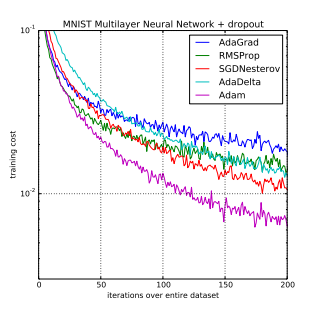

As we can see, the researchers showed that Adam was able to minimize the loss in a better rate than the other optimizers.

## Results 200 epochs different weights

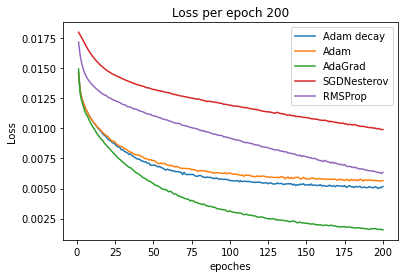

In [106]:
plt.plot(np.arange(1,epochs+1), loss_adam_decay_200, label='Adam decay')
plt.plot(np.arange(1,epochs+1), loss_adam_200, label='Adam')
plt.plot(np.arange(1,epochs+1), loss_adagrad_200, label='AdaGrad')
plt.plot(np.arange(1,epochs+1), loss_nesterov_200, label='SGDNesterov')
plt.plot(np.arange(1,epochs+1), loss_rmsprop_200, label='RMSProp')
plt.legend()
plt.title("Loss per epoch 200")
plt.xlabel("epoches")
plt.ylabel("Loss")
plt.show()

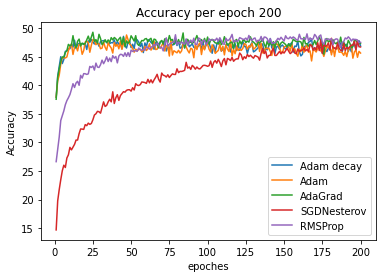

In [107]:
plt.plot(np.arange(1,epochs+1), acc_adam_decay, label='Adam decay')
plt.plot(np.arange(1,epochs+1), acc_adam, label='Adam')
plt.plot(np.arange(1,epochs+1), acc_adagrad, label='AdaGrad')
plt.plot(np.arange(1,epochs+1), acc_nesterov, label='SGDNesterov')
plt.plot(np.arange(1,epochs+1), acc_rmsprop, label='RMSProp')
plt.legend()
plt.title("Accuracy per epoch 200")
plt.xlabel("epoches")
plt.ylabel("Accuracy")
plt.show()

 - Here we can see that AdaGrad was the best optimizer, and Adam is in second place.
 - This shows us the importance of the parameter initialization for the results.
 - We also ploted the accuracy for our interest, but it is not realy relevant for the conclusions.

### Results 200 epochs with same weight initialization

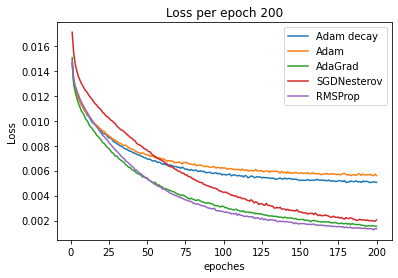

In [116]:
plt.plot(np.arange(1,epochs+1), loss_adam_decay_200_same, label='Adam decay')
plt.plot(np.arange(1,epochs+1), loss_adam_200_same, label='Adam')
plt.plot(np.arange(1,epochs+1), loss_adagrad_200_same, label='AdaGrad')
plt.plot(np.arange(1,epochs+1), loss_nesterov_200_same, label='SGDNesterov')
plt.plot(np.arange(1,epochs+1), loss_rmsprop_200_same, label='RMSProp')
plt.legend()
plt.title("Loss per epoch 200")
plt.xlabel("epoches")
plt.ylabel("Loss")
plt.show()

 - Adam is in the last place among all other methods.
 - This graph might imply that the learning rate is not good enough.
 - We think that the differences between our results and the paper results are resulting from bad hyperparameters. 
 - Howerver, we also need to state that the hyperparameters were not stated in the paper. 
 - In addition, several times we saw other optimizers outperform Adam.
 - Also, Adagrad that was the worst in the paper got better results in our experiments.